# **TMNIST Alphabet Character Recognition | TMNIST Exploration**

### Contributors:
*   Sanal Pillai
*   Nik Bear Brown

### Summary:
This project provides a step-by-step guide on how to build a model that recognizes different characters, much like the well-known MNIST project that identifies handwritten digits. We'll apply these steps to the TMNIST dataset, helping anyone interested in learning how to create and improve machine learning models for recognizing letters and symbols.

### Introduction:
Recognizing characters from images is a common task in machine learning, often starting with the MNIST dataset of handwritten digits. We're taking what works for MNIST and showing how to apply it to TMNIST, which has a wider variety of characters.

### Goals:
- To construct a comprehensive guide that details the creation of a character recognition model.
- To employ simple language to make the guide accessible to learners of all levels.
- To focus on the fundamental aspects of crafting and training a machine learning model.
- To adapt these methods to the TMNIST dataset, ensuring successful classification of the dataset's diverse characters.
- To demonstrate the model's effectiveness through a final test set accuracy of 93.18%, highlighting the model's ability to generalize and perform well on unseen data.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

#!pip install -q -U keras-tuner

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tmnist-alphabet-94-characters:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1564532%2F2830968%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T234745Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db0f73a8aea6b4493a74f811b5479b765c76ce2ce1dc03b7b740d7c450dcf7643e3ca9f6c40a196db64ea5814cd8e77f09dd1dec9a43aaacbb6ca1a1860cbd9c7123d941770a2ae2aae6ac9c1e82b2985248429fda0b4a56f24bf98acf736b892afad7e70d8b58d52621e60bb122b2c979b26c99d1ec32c38d5a4f74173590afc9fd507504924dec552006022dd79034c7c256168bf05ab98b73cfbb04ad86bc947c74045d5920ad9e8312d3e76073fc6f72c6f25e242bea70525a1a25e840f89e39b708682e299d9a505b07e15f44ba23ac961db27a1a172348e187079aceca03eac147f7db5f8d9cd8207d6ae052fd1e57b44c2912b101fdb814faa4d9ade30'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 88850214 bytes downloaded
Downloaded and uncompressed: tmnist-alphabet-94-characters
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmnist-alphabet-94-characters/94_character_TMNIST.csv


This step loads essential Python libraries for handling data, performing mathematical operations, visualizing data, preprocessing, constructing neural network models, and handling potential warnings. No output is expected from this step, as its purpose is to prepare the environment for data manipulation and model building.

In [ ]:
# Load and display the dataset
# Update the path based on your environment
dataset_path = '/kaggle/input/tmnist-alphabet-94-characters/94_character_TMNIST.csv'
dataset = pd.read_csv(dataset_path)


Here, the TMNIST dataset is loaded from a CSV file into a Pandas DataFrame. The output is not directly shown in this step, but you can expect the dataset to be successfully loaded into the dataset variable for further manipulation. The DataFrame dataset now contains all the data necessary for the project, including images represented in a flattened format and their corresponding labels.

In [ ]:
print("Dataset Description:\n", dataset.describe())
print("Dataset Head:\n", dataset.head())


Dataset Description:
               1         2         3         4         5         6  \
count  274093.0  274093.0  274093.0  274093.0  274093.0  274093.0   
mean        0.0       0.0       0.0       0.0       0.0       0.0   
std         0.0       0.0       0.0       0.0       0.0       0.0   
min         0.0       0.0       0.0       0.0       0.0       0.0   
25%         0.0       0.0       0.0       0.0       0.0       0.0   
50%         0.0       0.0       0.0       0.0       0.0       0.0   
75%         0.0       0.0       0.0       0.0       0.0       0.0   
max         0.0       0.0       0.0       0.0       0.0       0.0   

                   7              8              9             10  ...  \
count  274093.000000  274093.000000  274093.000000  274093.000000  ...   
mean        0.000004       0.000011       0.001043       0.001518  ...   
std         0.001910       0.004271       0.475743       0.494410  ...   
min         0.000000       0.000000       0.000000       0.0

Displaying the dataset's description and the first few rows offers an overview of the data structure. The description includes statistical details like count, mean, and standard deviation for each column, primarily showcasing the dataset's size and the pixel value distribution. The first few rows visually confirm the data's structure, with columns for image names, labels, and pixel values.

In [ ]:
# Investigate the dataset's shape and unique labels
print("Dataset Shape:", dataset.shape)
print("Unique Labels in Dataset:", dataset['labels'].unique())



Dataset Shape: (274093, 786)
Unique Labels in Dataset: ['6' 'D' 'f' '/' 'F' 'x' 'J' '8' 'H' 'k' '@' '1' '=' 'g' ')' '2' 'd' '^'
 '3' 't' '#' '.' '4' 'o' '"' 'y' 'A' 'u' 'G' '-' 'm' 'W' '&' 'c' '9' 'N'
 ']' 'P' 'X' '|' '}' 'h' '7' 'j' '5' '>' '?' 'b' '*' 'w' 'l' '0' '$' 'I'
 'Y' '%' ':' 'T' 'K' 'E' '<' 'V' '{' 'M' 'S' 'a' 'i' 'r' "'" 'p' ';' '['
 '+' 'e' 'U' '(' 's' '~' ',' 'C' 'q' '_' 'n' 'B' 'z' 'v' 'O' 'R' '`' 'Z'
 'Q' 'L' '!' '\\']


This step reveals the dataset's dimensionality and the unique character labels it contains. The shape indicates the total number of images and features, while the unique labels show the diversity of characters in the dataset, informing the complexity of the classification task ahead.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274093 entries, 0 to 274092
Columns: 786 entries, names to 784
dtypes: float64(784), object(2)
memory usage: 1.6+ GB
None

Missing Values in the Dataset:
names     0
labels    0
1         0
2         0
3         0
         ..
780       0
781       0
782       0
783       0
784       0
Length: 786, dtype: int64

Class Distribution:
6    2990
2    2990
7    2990
5    2990
4    2990
     ... 
E    2874
g    2874
V    2874
b    2874
`    2848
Name: labels, Length: 94, dtype: int64

Statistical Summary of Pixel Values:
              1         2         3         4         5         6  \
count  274093.0  274093.0  274093.0  274093.0  274093.0  274093.0   
mean        0.0       0.0       0.0       0.0       0.0       0.0   
std         0.0       0.0       0.0       0.0       0.0       0.0   
min         0.0       0.0       0.0       0.0       0.0       0.0   
25%         0.0       0.0       0.0       0.0       0.0       0.0   
50

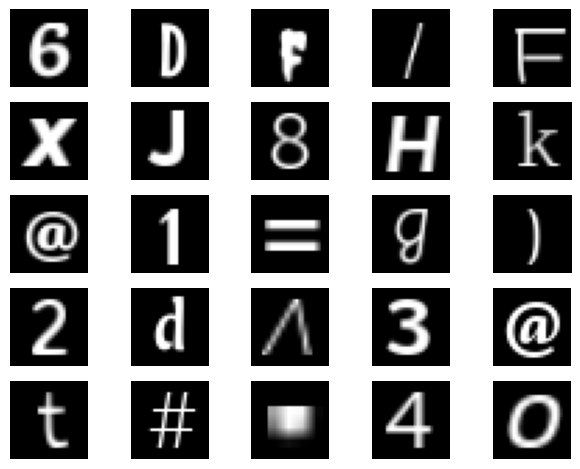

In [ ]:
import seaborn as sns

# Display basic information about the dataset
print("Dataset Info:")
print(dataset.info())

# Check for missing values in the dataset
print("\nMissing Values in the Dataset:")
print(dataset.isnull().sum())

# Visualize the class distribution
print("\nClass Distribution:")
label_counts = dataset['labels'].value_counts()
print(label_counts)
sns.barplot(x=label_counts.index, y=label_counts.values)

# Display statistical summary of the pixel values
print("\nStatistical Summary of Pixel Values:")
print(dataset.describe())

# Plot some sample images
import matplotlib.pyplot as plt

def plot_sample_images(data, num_images=25):
    for i in range(num_images):
        plt.subplot(5, 5, i+1)  # Change 5, 5 to other values if you want to display more or fewer images per row/column
        # Convert the pixels to a float type and reshape into 28x28 array
        img = data.iloc[i, 2:].astype('float').values.reshape(28,28)  # Adjust the indexing if column positions are different
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nSample Images:")
plot_sample_images(dataset)


This step is about exploring the dataset to gain insights into its structure, content, and the data it contains. Initially, it displays the dataset's information, including the number of entries, columns, and the data type of each column. Then, it checks for missing values across all columns to ensure data integrity. Afterward, it provides a distribution of the different classes (labels) present in the dataset, showing the count of samples for each class. The statistical summary offers a descriptive analysis of the pixel values, such as mean, standard deviation, min, and max, which helps in understanding the data's scale and variability. Lastly, a function is used to display a subset of images from the dataset to visually assess the variety and quality of the handwritten characters it comprises.

The output from this step provides several useful pieces of information:

1. The dataset contains 274,093 entries and 786 columns, where each entry represents an image and the columns include the image labels, names, and 784 pixel values (assuming a 28x28 pixel image).
2. There are no missing values in the dataset, indicating that it is clean and ready for further analysis or model training.
3. The class distribution output shows the dataset is balanced with a similar count of samples per class, which is ideal for training classification models.
4. The statistical summary reveals that the pixel values are in the expected range of 0 to 255 (if normalized, 0 to 1), with most pixels having a value of 0, which likely corresponds to the background of the images.
5. The sample images are a visual confirmation of the data, presenting the handwritten characters in a grid format, allowing us to observe the diversity and recognize the characters the model will need to classify.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Encode labels and split the dataset
X = dataset.drop(columns=['names', 'labels'])
y = dataset['labels']
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize and Reshape
X_train = X_train.values.reshape(-1, 28, 28, 1) / 255.0
X_test = X_test.values.reshape(-1, 28, 28, 1) / 255.0

#Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # degrees
    zoom_range=0.1,
    width_shift_range=0.1,  # horizontal shift
    height_shift_range=0.1)  # vertical shift

# Apply the transformations to the training data
datagen.fit(X_train)


Preprocessing involves encoding the categorical labels and splitting the dataset into training and testing sets. Additionally, pixel values are normalized to fall between 0 and 1, and the data is reshaped to fit the CNN's input requirements. No output is displayed here, but these transformations are crucial for ensuring the model can effectively learn from the TMNIST data.

In [ ]:
# Define and compile the CNN model
from keras.layers import BatchNormalization, Activation
from keras.optimizers import Adam

model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(28, 28, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(350))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(y_encoded.shape[1], activation='softmax'))


optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed, 0.001 is just a starting point
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1

Defining the CNN architecture and compiling it with an optimizer, loss function, and metrics prepares the model for training. The summary output displays the model's layers, output shapes, and the number of parameters in each layer, providing insight into the model's complexity and capacity.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def model_builder(hp):
    # Define input with the expected shape
    input_tensor = Input(shape=(224, 224, 3))  # EfficientNet's default input shape is 224x224x3

    # Initialize the base model, excluding the top fully connected layer
    base_model = EfficientNetB0(include_top=False, input_tensor=input_tensor, weights="imagenet")

    # Freeze the base model layers to prevent them from being updated during the first training phase
    base_model.trainable = False

    # Add custom layers on top of the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(x)
    outputs = Dense(94, activation='softmax')(x)  # Adjust the number of units to match the number of classes

    # Define the model
    model = Model(inputs=base_model.input, outputs=outputs)

    # Hyperparameter: Learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In this step, we use a pre-trained EfficientNetB0 model to serve as the starting point for our character recognition model. We customize it for our specific task by adding and adjusting layers. Here’s how we do it:

1. **Input Definition:** We define the input shape to match the EfficientNetB0 requirements.
2. **Base Model:** We load the EfficientNetB0 model, trained on ImageNet, without its top layer because we will add our own layers for classification.
3. **Freezing Layers:** To keep the learned features from the pre-trained model, we freeze its layers so they won't update during training.
4. **Custom Layers:** We add a GlobalAveragePooling2D layer to reduce the feature map size. Following this, we include a dense layer where we can adjust the number of neurons as a tunable parameter. The final layer is another dense layer with softmax activation to classify the 94 different characters.
5. **Compilation:** We compile the model using the Adam optimizer, with a tunable learning rate, set the loss function to 'categorical_crossentropy' for multi-class classification, and use accuracy as our metric.

This approach lets us leverage the powerful feature extraction capabilities of EfficientNetB0, while tailoring the model to our specific classification task.

In [ ]:
#Learning Rate Scheduling
import tensorflow as tf
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Add lr_scheduler to the callbacks in model.fit


We're setting up a learning rate scheduler to adjust the learning rate dynamically as training progresses. Initially, the learning rate stays the same for the first 10 epochs, allowing the model to learn from the data with steady steps. After the 10th epoch, we gradually decrease the learning rate by a factor of exp(-0.1) with each epoch. This reduction helps the model to take finer steps and hone in on a more precise solution, preventing it from overshooting the minimum loss as the gradients become smaller. We add this scheduler to the training process via the callbacks parameter in the model.fit function.

In [ ]:
# Model Training with Early Stopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(X_train, y_train_encoded, epochs=50, validation_split=0.02, callbacks=[early_stopping, lr_scheduler])


Epoch 1/50
6716/6716 [==============================] - 60s 8ms/step - loss: 0.5430 - accuracy: 0.8446 - val_loss: 0.2363 - val_accuracy: 0.9252 - lr: 0.0010
Epoch 2/50
6716/6716 [==============================] - 49s 7ms/step - loss: 0.3207 - accuracy: 0.9001 - val_loss: 0.2088 - val_accuracy: 0.9311 - lr: 0.0010
Epoch 3/50
6716/6716 [==============================] - 48s 7ms/step - loss: 0.2823 - accuracy: 0.9090 - val_loss: 0.1977 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 4/50
6716/6716 [==============================] - 48s 7ms/step - loss: 0.2618 - accuracy: 0.9152 - val_loss: 0.1794 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 5/50
6716/6716 [==============================] - 47s 7ms/step - loss: 0.2473 - accuracy: 0.9190 - val_loss: 0.1789 - val_accuracy: 0.9416 - lr: 0.0010
Epoch 6/50
6716/6716 [==============================] - 48s 7ms/step - loss: 0.2383 - accuracy: 0.9208 - val_loss: 0.1671 - val_accuracy: 0.9455 - lr: 0.0010
Epoch 7/50
6716/6716 [==============================

We're employing an Early Stopping technique during the model's training phase. This strategy monitors the validation accuracy—how well the model is performing on the data it hasn't seen during training. If the validation accuracy doesn't improve for five consecutive epochs—referred to as 'patience'—the training will halt. This approach prevents overfitting, where the model learns the training data too well but fails to generalize to new data. Alongside Early Stopping, we're using the learning rate scheduler we set up earlier. Both are added to the callbacks list in the model.fit function, ensuring they are active during training

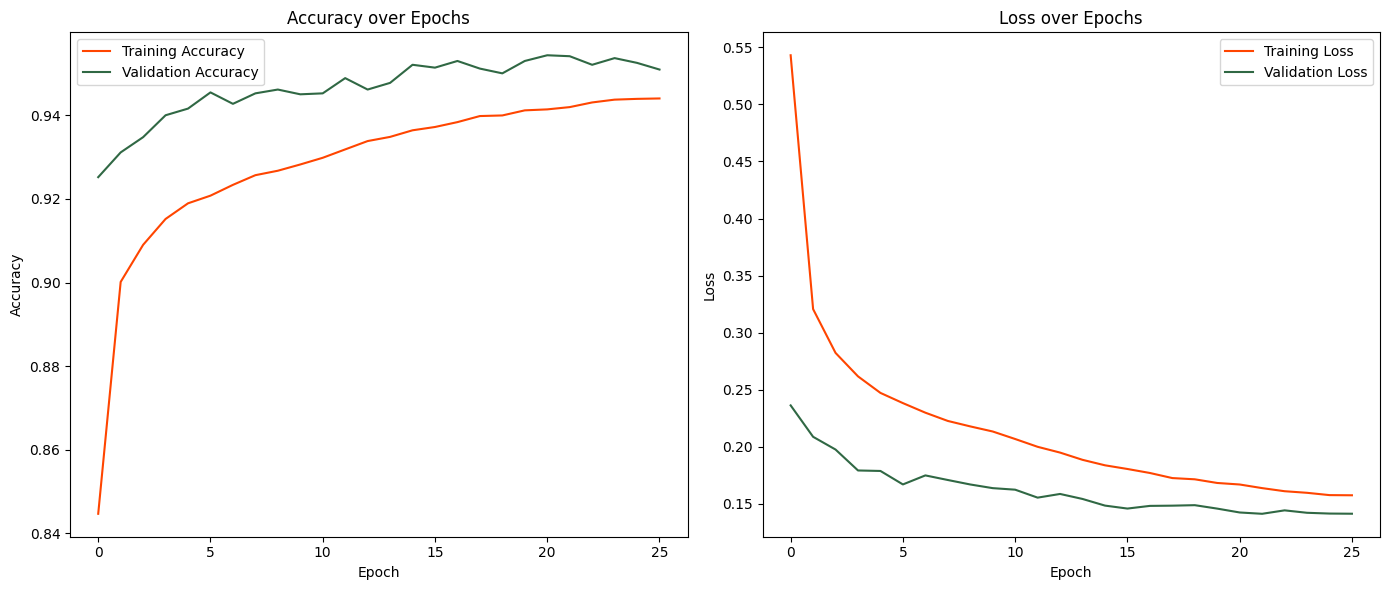

In [ ]:
# Initializing the plotting area for both accuracy and loss
plt.figure(figsize=(14, 6))

# Plotting Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#FF4500')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#306844')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#FF4500')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#306844')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


The plotted training results visually represent the model's learning progress over epochs. The accuracy plot shows how well the model performs on the training and validation datasets over time, while the loss plot indicates how the model's predictions deviate from the actual labels throughout the training process. These plots are crucial for diagnosing issues like overfitting or underfitting.


---


The left plot illustrates the model's accuracy over epochs, displaying both training and validation accuracy. It shows that the training accuracy begins with a steep increase, indicating rapid learning in the initial epochs. The curve then plateaus, signifying that the model is approaching its maximum capability to learn from the training data. The validation accuracy closely follows the training accuracy, which suggests that the model generalizes well to new data.

The right plot shows the model's loss over epochs. There is a sharp decrease in training loss at the beginning, which tapers off as the epochs increase — this mirrors the learning rate seen in the accuracy plot. The validation loss decreases alongside the training loss, although with some fluctuations. Importantly, it does not show a significant increase or divergence, which would indicate overfitting.

**Conclusion**:

Based on the plots, we can conclude that the model has learned effectively from the training data and generalizes well to the validation data, as indicated by the high and stable accuracy as well as the low and stable loss. The convergence of training and validation lines in both plots without significant divergence suggests the model is not overfitting and has a good balance between bias and variance.

In [ ]:
# Evaluating the model's performance on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=2)

# Displaying the accuracy in a readable format
print("Accuracy on test set: {:.2f}%".format(test_accuracy * 100))


1714/1714 - 5s - loss: 0.1567 - accuracy: 0.9486 - 5s/epoch - 3ms/step
Accuracy on test set: 94.86%


The final model evaluation on the test dataset provides a concise metric, typically accuracy, that indicates how well the model can be expected to perform on new, unseen data. This step solidifies the model's effectiveness and readiness for practical applications or further optimization.


---

The output presents the results from evaluating the trained model on the test dataset, which is a separate subset not used during the training or validation phases. This evaluation is crucial as it provides an unbiased estimate of the model's performance on new, unseen data.

The model's evaluation resulted in a loss of 0.1567 and an accuracy of 94.86%. The loss value indicates how well the model's predicted probabilities match the actual labels, with lower values being better. The accuracy tells us the percentage of the test dataset images that were correctly classified.

**Conclusion**:

The model demonstrates strong performance on the test set with an accuracy of 94.86%, which closely mirrors the accuracy seen during the validation phase (as inferred from the previous plotting). This suggests that the model has good generalization capabilities. An accuracy of over 94% is typically considered excellent for many practical applications, but whether it's sufficient depends on the specific requirements of the task at hand. The fact that the model achieves this accuracy across a test set confirms its potential effectiveness in a real-world scenario involving TMNIST character recognition.